In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
from shapely.geometry import mapping
from cmcrameri import cm
import matplotlib as mpl

ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
##clip cru to amz shp
#from shapely.geometry import mapping

datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
import regionmask
regions = gpd.read_file(r'Data\regions1.geojson')
#rename region to Region
regions = regions.rename(columns={'region':'Region'})
regions_mask = regionmask.from_geopandas(regions, names='Region')
regions_list = ['Central' , 'Southern', 'Eastern']
regions_replace = { 0:'Central', 1:'Southern',2:'Eastern'}
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})

letters_22 = ['j)', 'k)', 'l)', 'm)']
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]



# Setup

In [ ]:
folder_clean = r'Data\Datasets\clean'
folder_metric = r'Data\Datasets\Cerrado_map'
#filter from 2001 to 2020
begin_date = '2001-01-01'
end_date = '2020-12-31'
lat_min = -25
lat_max = 0
lon_min = -63
lon_max = -41

In [14]:
from pymannkendall import original_test

# functions
def mannkendall_trend(arr):
    if not np.isnan(arr).any():
        result = original_test(arr)
        return result.p, result.slope, result.intercept
    else:
        return np.nan, np.nan, np.nan

def ds_kendall(data, dim):
    results =  xr.apply_ufunc(mannkendall_trend, data,
                             input_core_dims=[[dim]],
                             output_core_dims=[[], [],[]],
                             vectorize=True,
                             dask='parallelized')
    
    
    # Extract the p-values and Sen's slopes from the results
    p_values = results[0]
    slopes = results[1]
    intercepts = results[2]
    
    # Create a new xarray dataset to store the results
    results_dataset = xr.Dataset({'p_values': p_values.pr, 'slopes': slopes.pr, 'intercepts': intercepts.pr})
    return results_dataset

In [15]:
#cut datasets and calculate map
for dataset in datasets:
    #read file of dataset in folder_clean
    file_path = glob(os.path.join(folder_clean, dataset + '.nc'))
    ds = xr.open_dataset(file_path[0]).sel(time=slice(begin_date, end_date), lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    ds_cer = ds.rio.write_crs(shp_cerrado.crs).rio.set_spatial_dims(x_dim='lon', y_dim='lat').rio.clip(shp_cerrado.geometry.apply(mapping),shp_cerrado.crs, drop=False)
    #save clipped dataset
    if dataset == 'terra':
        vars_list = list(ds_cer.data_vars)  
        for var in vars_list:  
            del ds_cer[var].attrs['grid_mapping']
    print('cut', dataset)

    ds_ts = ds_cer.groupby('time.year').mean('time')
    #pr times 12
    ds_ts['pr'] = ds_ts['pr'] * 12
    ds_clim = ds_ts.mean('year')
    ds_trend =  ds_kendall(ds_ts, 'year')
    #save
    ds_ts.to_netcdf(os.path.join(folder_metric, dataset + '.nc'))
    ds_clim.to_netcdf(os.path.join(folder_metric,'clim', dataset + '.nc'))
    ds_trend.to_netcdf(os.path.join(folder_metric,'trend', dataset + '.nc'))
    print('done', dataset)


cut cru
done cru
cut gpcc
done gpcc
cut chirps
done chirps
cut imerg
done imerg
cut terra
done terra
cut era_land
done era_land
cut jra55
done jra55
cut merra2
done merra2


# stations

In [106]:
codes_to_del = [2246192,2246191,2551008,2452001,2352029,2452000,2352063,2551010,2352033,53080010]

In [107]:
regions = gpd.read_file(r'Data\regions1.geojson')
#stations geodataframe
gdf = gpd.read_file(r'Data\stations_all.geojson').to_crs(shp_cerrado.crs)
# rainfall cleaned data
df_bet= pd.read_pickle('Data\ALL_01_20_20bet.pkl')
#take out stations in codes_to_del
df_bet = df_bet[~df_bet.Code.isin(codes_to_del)]
gdf_filtered = gdf[gdf.Code.isin(df_bet.Code.unique())].to_crs(shp_cerrado.crs)
#spatial join gdf_filtered and bacias_amz
gdf_filtered = gpd.sjoin(gdf_filtered, regions, how='inner', op='intersects')
#rename region to Region
gdf_filtered = gdf_filtered.rename(columns={'region': 'Region'})
df_cer = df_bet[df_bet.Code.isin(gdf_filtered.Code.unique())]
gdf_filtered.to_file(r'Data\Evaluation\stations_cer_ANA.geojson', driver='GeoJSON')
df_cer.to_pickle(r'Data\Evaluation\cer_01_20_20bet.pkl')
gdf_filtered.groupby('Region').count()


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\653835595.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_ ...
Right CRS: EPSG:4674

  gdf_filtered = gpd.sjoin(gdf_filtered, regions, how='inner', op='intersects')


Code  Name  Latitude  Longitude  Altitude  first_records  \
Region                                                               
Central    349   349       349        349       318            349   
Eastern    154   154       154        154       107            154   
Southern   113   113       113        113       105            113   

          last_records  Duration  geometry  index_right   ID  
Region                                                        
Central            349       349       349          349  349  
Eastern            154       154       154          154  154  
Southern           113       113       113          113  113

In [108]:
stations = gpd.read_file(r'Data\Evaluation\stations_cer_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\cer_01_20_20bet.pkl')
df_ts = df_stat.groupby(['Code',df_stat.Date.dt.year]).sum().reset_index()
df_clim = df_ts.groupby('Code').mean().reset_index()
stations = stations.merge(df_clim, on='Code')
for code in df_ts.Code.unique():
    test = original_test(df_ts[df_ts.Code == code]['Total'])
    stations.loc[stations.Code == code, 'p'+ '_' + 'anual'] = test.p
    stations.loc[stations.Code == code, 'slope'+ '_' + 'anual'] = test.slope
    stations.loc[stations.Code == code, 'intercept'+ '_' + 'anual'] = test.intercept

#save stations as stations map
stations.to_file(os.path.join(folder_metric, 'stations.geojson'), driver='GeoJSON')
df_ts.to_csv(os.path.join(folder_metric, 'stations_ts.csv'))

C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3935922963.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = df_stat.groupby(['Code',df_stat.Date.dt.year]).sum().reset_index()


# Clim

In [109]:
stations = gpd.read_file(r'Data\Datasets\Cerrado_map\stations.geojson')
folder_metric = r'Data\Datasets\Cerrado_map\clim'
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds

#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df_stat = stations[['Total', 'Region']].copy()
df_stat['Dataset'] = 'Stations'
df_stat = df_stat.rename(columns={'Total':'pr'})
df = df.append(df_stat)

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3348938337.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3348938337.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [110]:
vmin = 400
vmax = 2000
levels = 9
cmap =  cm.lapaz_r#cmocean.cm.rain#mpl.cm.Blues
extend_cbar = 'both'
var = 'pr'
var_stat = 'Total'
label_cbar = 'Mean Annual Precipitation (mm/year)'
extent = [-61, -41, -25, -1]

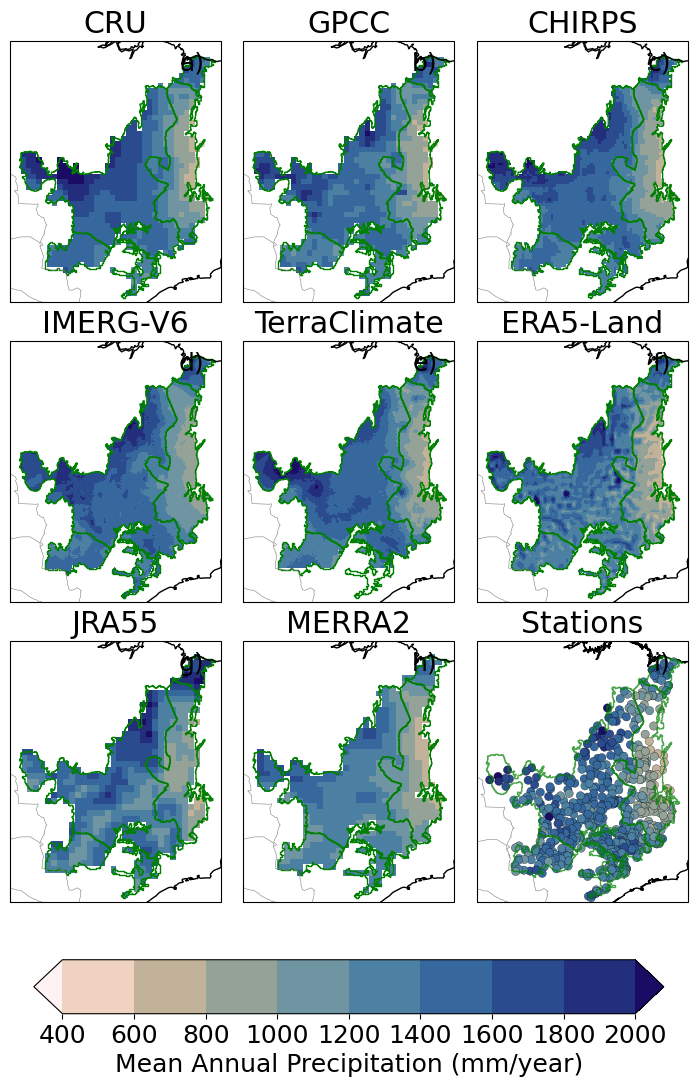

In [111]:
from Data.utils.datasets_plotting import plot_datasets33
fig = plt.figure(layout='constrained', figsize=(7, 9))
plot_datasets33(fig, datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar,extent = extent)
fig.axes[-1].set_position([0.05, -0.12, 0.9, 0.06])

## pixel

In [112]:
#merge with stations to get the region
df_stat = stations.copy()
df_stat = df_stat.rename(columns={'Total':'pr'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry',  'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

pixel_dict = {}

for name in datasets_names:
    ds = ds_dict[name].copy()

    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values

    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

    # Step 3: Compute the mean value for each grid cell and each year
    grid_cells = data.groupby([ 'lat_bin', 'lon_bin'])[var].mean().reset_index()

    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)

    # Step 5: Fill the DataArray with the computed mean values for each year
    for _, row in grid_cells.iterrows():
        #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)

        empty_grid[lat_idx - 1, lon_idx - 1] = row[var]

    # Step 6: Create an xarray DataArray from the result with the year dimension
    #year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('lat', 'lon'),
                                coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    #data_array = data_array.to_dataset(name=var)
    #data_array['Region'] = ds['Region']
    ds['stat'] = data_array
    pixel_dict[name] = ds.where(ds.stat>= 0)


In [113]:
#create a df_p with all ds in ds_dict
df_p = pd.DataFrame()
for name in datasets_names:
    df_pf =  pixel_dict[name].to_dataframe().dropna().reset_index(drop=True)
    df_pf['Dataset'] = name
    df_p = df_p.append(df_pf)
df_p = df_p[['pr', 'Region', 'Dataset']]
df_p['Region'] = df_p['Region'].replace(regions_replace)
df_p_stat = stations[['Total', 'Region']].copy()
df_p_stat['Dataset'] = 'Stations'
df_p_stat = df_p_stat.rename(columns={'Total':'pr'})
df_p = df_p.append(df_p_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\637616759.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p = df_p.append(df_pf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\637616759.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p = df_p.append(df_pf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\637616759.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p = df_p.append(df_pf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\637616759.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p = df_p.append(df_pf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\637616759.py:6: FutureWarning: The frame.a

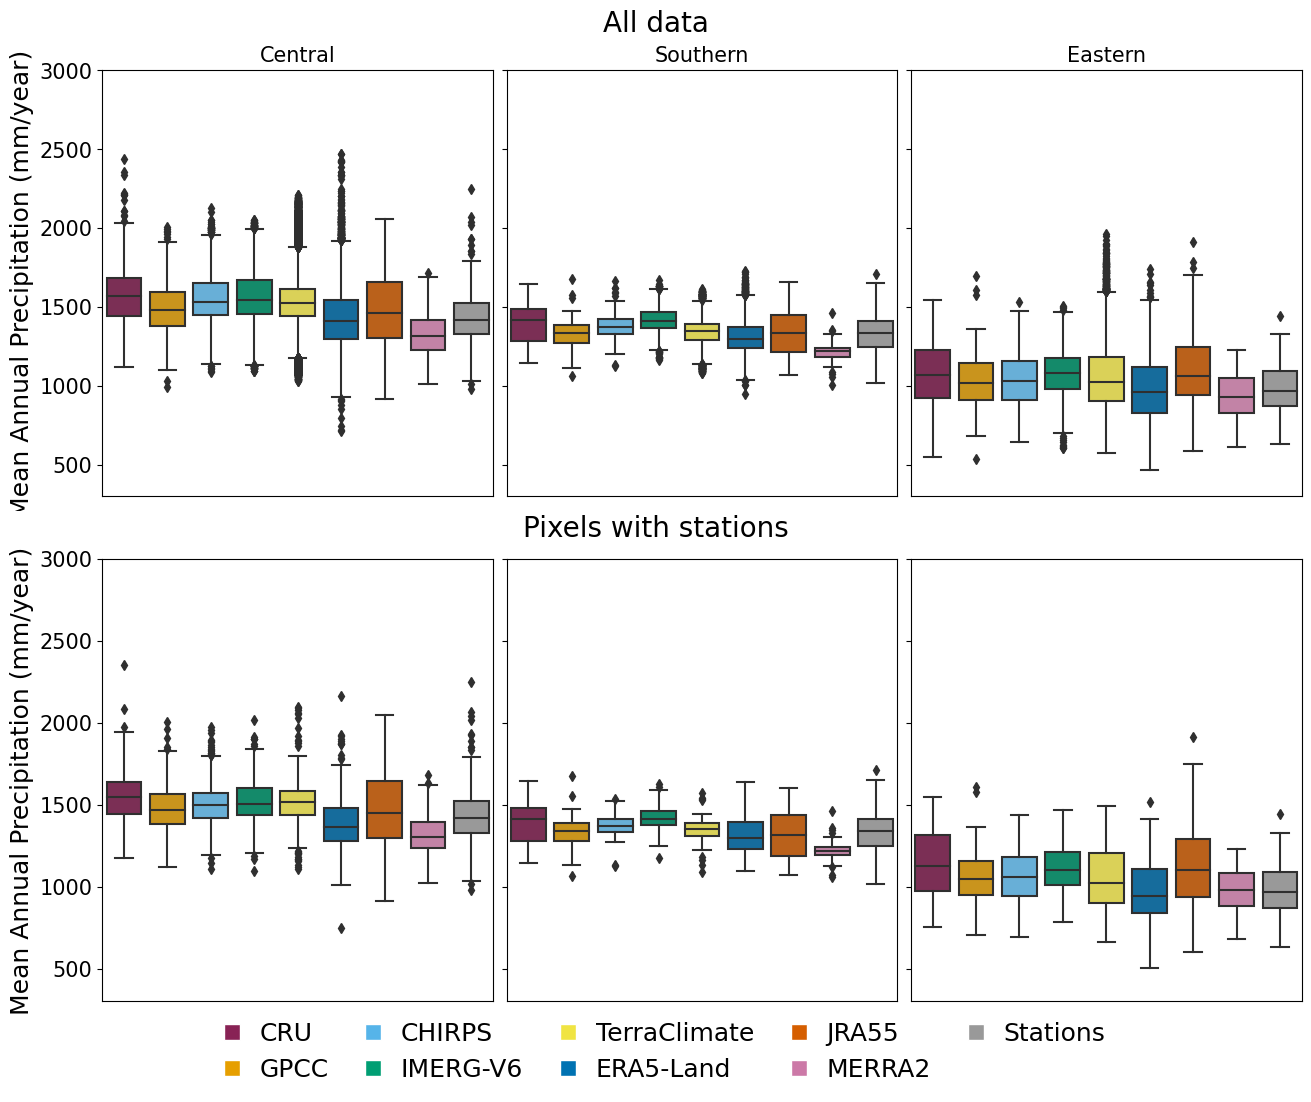

In [114]:
#plot df and df_p for each region

fig = plt.figure(layout='constrained', figsize=(13, 10))
subfigs = fig.subfigures(2, 1)
for i, dff in enumerate([df,df_p]):
    axs = subfigs[i].subplots(1, 3, sharex=True, sharey='row')
    axs = axs.flatten()
    for j, region in enumerate(regions_list):
        sns.boxplot( y='pr', data=dff[dff.Region==region], ax=axs[j], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
        
        axs[j].set_xlabel('')
        axs[j].tick_params(axis='y', which='both', labelsize=15)
        axs[j].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        axs[j].set_ylabel('')
        axs[j].set_ylim(300,3000)
        if i == 0:
            axs[j].set_title(region, fontsize=15)
    axs[0].set_ylabel(label_cbar)

subfigs[0].suptitle('All data', fontsize=20)
subfigs[1].suptitle('Pixels with stations', fontsize=20)

subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)
#plt.tight_layout()

In [115]:
#create a df with all ds in ds_dict
df_compare = pd.DataFrame()
for name in datasets_names:
    dff =  pixel_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df_compare = df_compare.append(dff)
df_compare = df_compare[['pr', 'Region', 'Dataset','stat']]
df_compare['Region'] = df_compare['Region'].replace(regions_replace)

C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1312172248.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1312172248.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1312172248.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1312172248.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2578

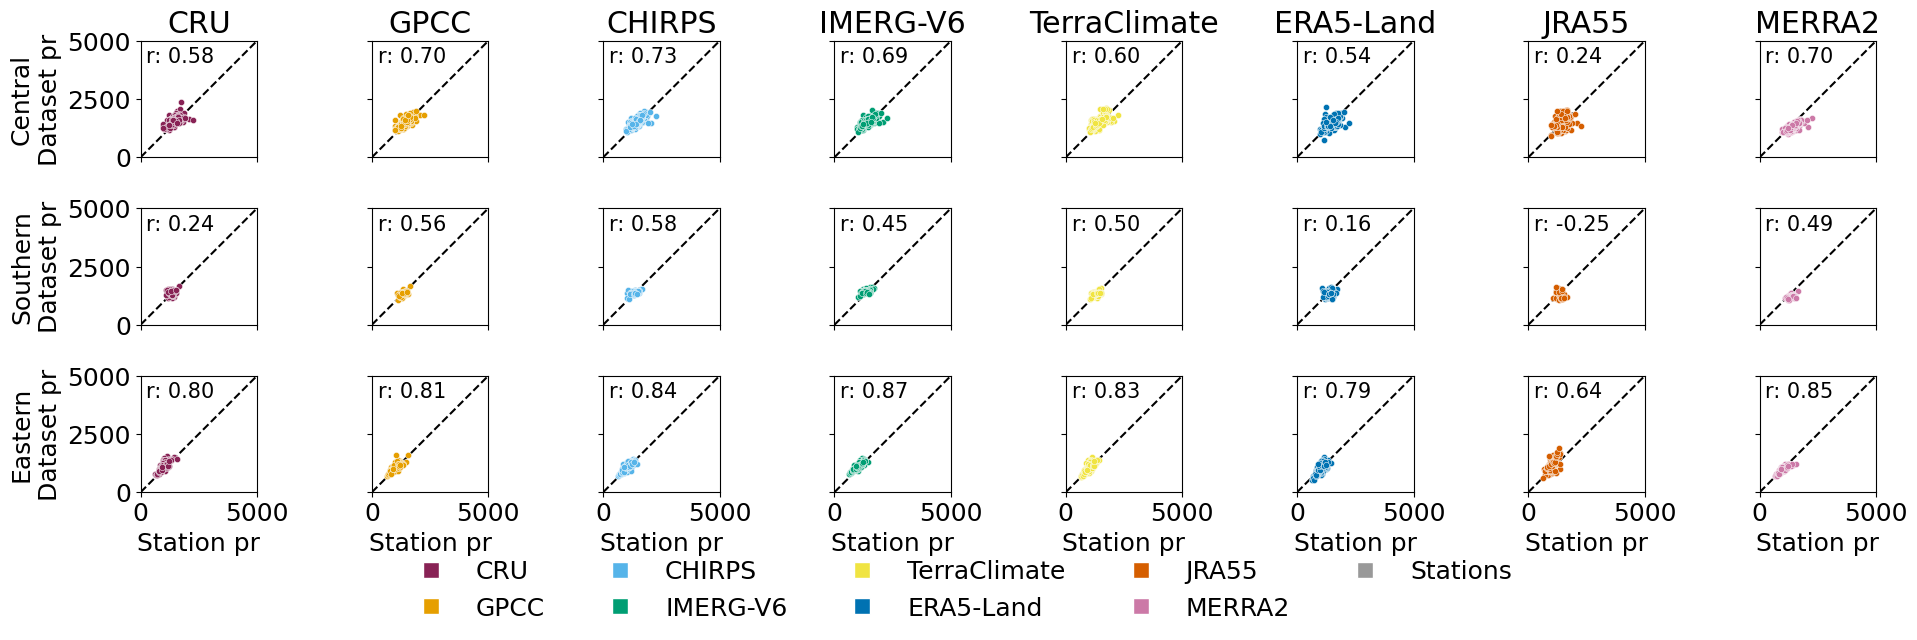

In [116]:
fig, axes = plt.subplots(3,8, figsize=(20,6), sharex=True, sharey=True)
limm = 5000
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='stat', y='pr', ax=axes[j,i], s=20, color=wong[i])
        
        axes[j,i].set_xlabel('Station pr')
        axes[j,i].set_ylabel(region + '\nDataset pr')
        axes[j,i].set_xlim(0,limm)
        axes[j,i].set_ylim(0,limm)
        axes[j,i].plot([0,limm],[0,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['stat'].corr(df_plot['pr'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

# TS

In [117]:
folder_metric = r'Data\Datasets\Cerrado_map'
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [118]:
df_stat = pd.read_csv(r'Data\Datasets\Cerrado_map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'
pixel_dict = {}

for name in datasets_names:
    ds = ds_dict[name].copy()

    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values

    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

    # Step 3: Compute the mean value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin'])[var].mean().reset_index()

    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)

    # Step 5: Fill the DataArray with the computed mean values for each year
    for _, row in grid_cells.iterrows():
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)

        empty_grid[year_idx, lat_idx - 1, lon_idx - 1] = row[var]

    # Step 6: Create an xarray DataArray from the result with the year dimension
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('year', 'lat', 'lon'),
                                coords={'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})



    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.pr >= 0)


In [119]:
df = pd.DataFrame()
for name in datasets_names:
    ds = pixel_dict[name]
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['year','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df_stat = pd.read_csv(r'Data\Datasets\Cerrado_map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code', 'Region']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
df_stat['Dataset'] = 'Stations'
df_stat = df_stat[['year', 'pr','Region', 'Dataset']]
df = df.append(df_stat)


C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)


C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1627752297.py:15: FutureWarning: The frame.append method is de

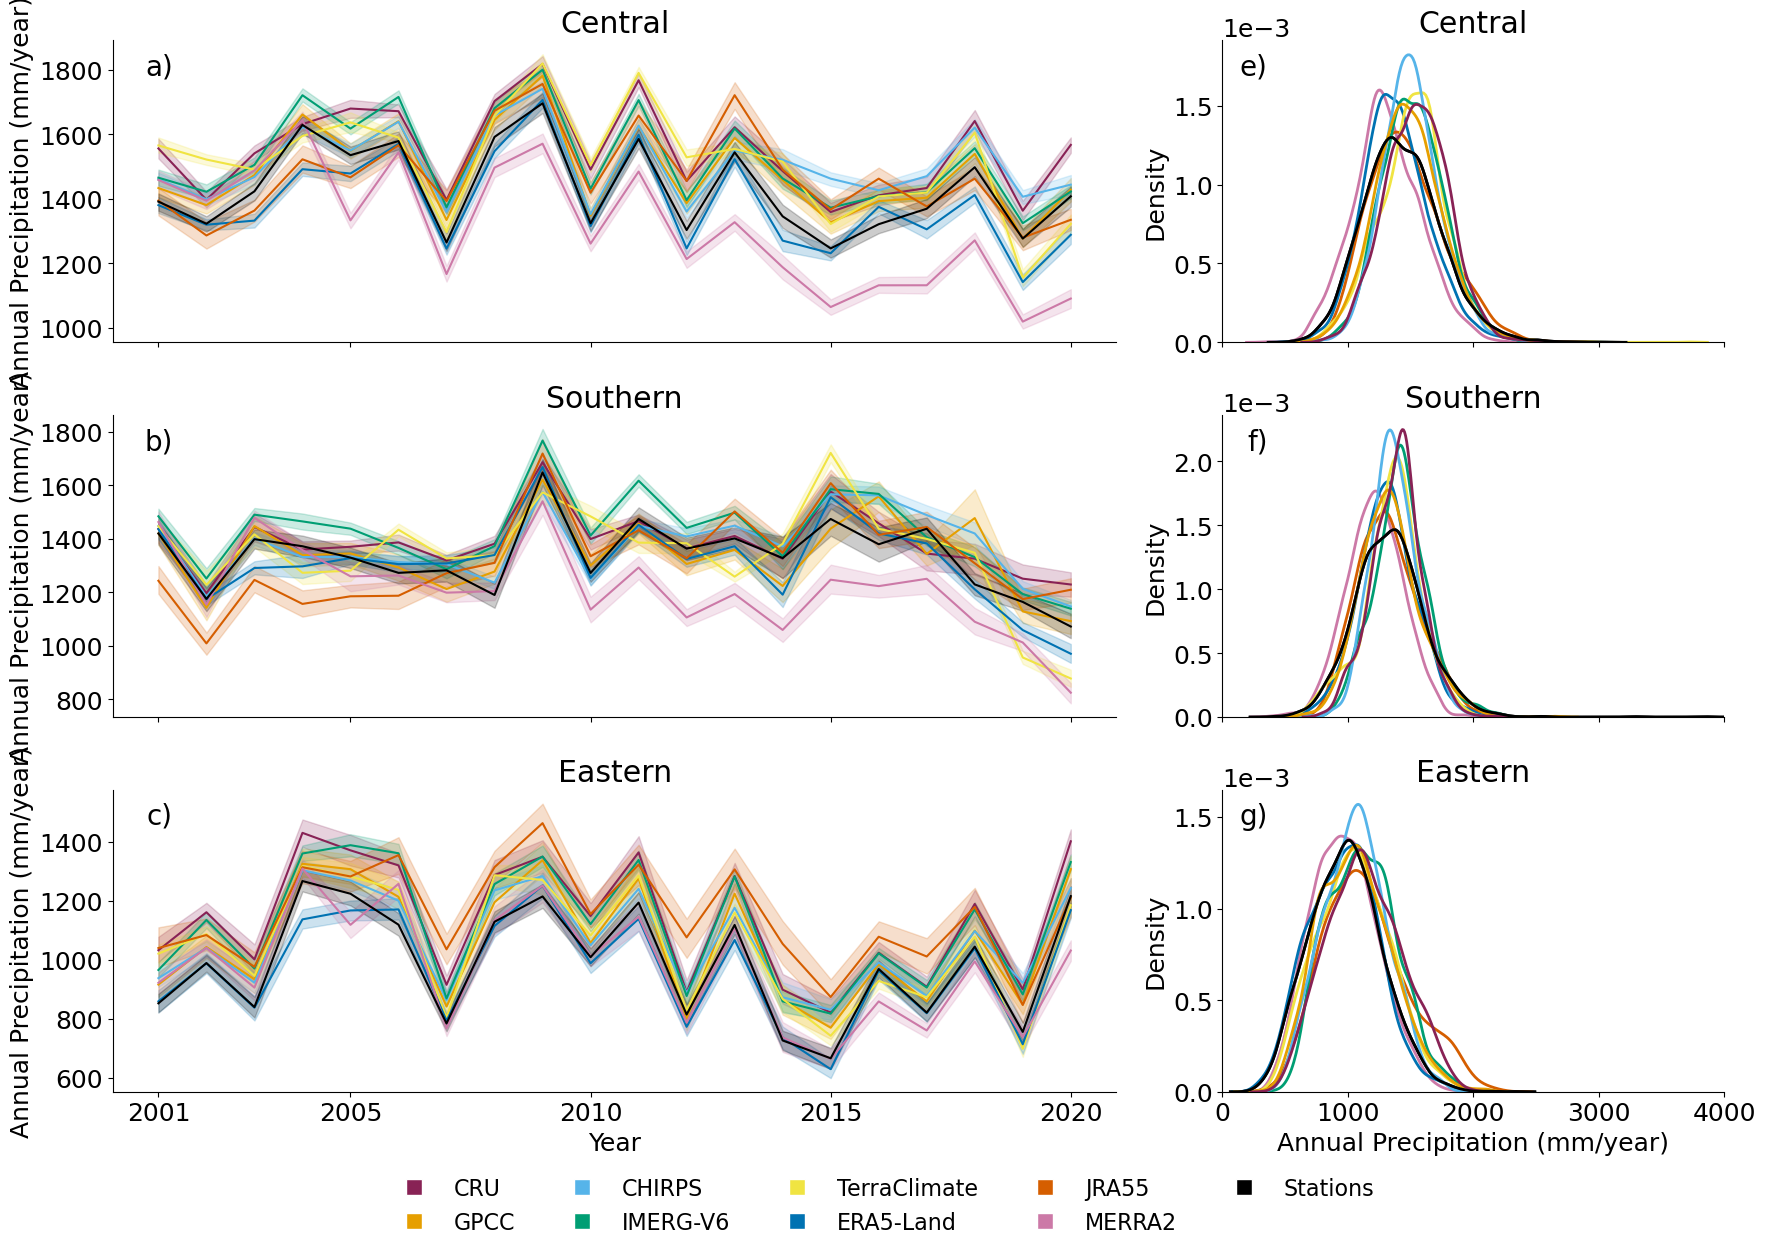

In [120]:
fig, axs = plt.subplots(3, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [2, 1]}, sharex='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_region = df[df['Region'] == region]
    sns.lineplot(data=df_region, ax=axs[i, 0], x='year', y='pr', hue='Dataset', palette=wong_b, hue_order=hue_order, legend=False)
    sns.kdeplot(data=df_region, ax=axs[i, 1], x='pr', hue='Dataset', fill=False, common_norm=False, linewidth=2,palette=wong_b, hue_order=hue_order, legend=False)
    sns.kdeplot(data=df_region[df_region.Dataset=='Stations'], x='pr', fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, 1], legend=False) 
    axs[i, 0].set_title(region)
    axs[i, 1].set_title(region)
    axs[i, 0].set_ylabel('Annual Precipitation (mm/year)')
    axs[i, 0].set_xlabel('Year')
    axs[i, 1].set_xlabel('Annual Precipitation (mm/year)')
    axs[i, 1].set_xlim(0, 4000)
    axs[i, 0].set_xticks([2001, 2005,2010, 2015, 2020])
    axs[i, 0].text(0.06,0.96,  letters_ts[i], transform=axs[i, 0].transAxes,  fontsize=20, va='top', ha='right')
    axs[i, 1].text(0.09,0.96,  letters_pdf[i], transform=axs[i, 1].transAxes,  fontsize=20, va='top', ha='right')   
    #Set axs[i, 1] y-axis as scientific notation
    axs[i, 1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #DESPINE
    sns.despine(ax=axs[i, 0], top=True, right=True, left=False, bottom=False)
    sns.despine(ax=axs[i, 1], top=True, right=True, left=False, bottom=False)
#create legend in the bottom center of the figure
fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)


plt.tight_layout()

## taylor

In [121]:
from Data.utils.taylor import *
from scipy.stats import pearsonr
df_mean = df.groupby(['year', 'Region', 'Dataset']).mean().reset_index()
#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
std_ref = []
for region in regions_list:
    df_region = df_mean[df_mean['Region'] == region]
    df_station = df_region[df_region['Dataset'] == 'Stations']
    for dataset in datasets_names:
        df_ds = df_region[df_region['Dataset'] == dataset]
        # do correlation
        corr = pearsonr(df_ds.pr.values, df_station.pr.values)[0].round(2)
        df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
        std_ref.append(df_station.pr.values.std())
        

C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std()}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\1594821198.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df

In [122]:
df_corr

Region       Dataset  corr        sd
0    Central           CRU  0.95  1.004036
1    Central          GPCC  0.98  0.998648
2    Central        CHIRPS  0.92  0.827416
3    Central      IMERG-V6  0.98  1.042889
4    Central  TerraClimate  0.81  1.181046
5    Central     ERA5-Land  0.94  1.070124
6    Central         JRA55  0.80  1.010818
7    Central        MERRA2  0.80  1.360500
8   Southern           CRU  0.86  0.845134
9   Southern          GPCC  0.80  1.055045
10  Southern        CHIRPS  0.88  0.959690
11  Southern      IMERG-V6  0.93  1.126935
12  Southern  TerraClimate  0.73  1.398333
13  Southern     ERA5-Land  0.90  1.187793
14  Southern         JRA55  0.74  1.248111
15  Southern        MERRA2  0.78  1.254918
16   Eastern           CRU  0.99  1.070547
17   Eastern          GPCC  0.98  1.034197
18   Eastern        CHIRPS  0.98  0.869656
19   Eastern      IMERG-V6  0.98  1.079779
20   Eastern  TerraClimate  0.95  1.048857
21   Eastern     ERA5-Land  0.98  0.960743
22   Eastern         JRA55  0.90  0.874223
23   Eastern        MERRA2  0.93  1.015044

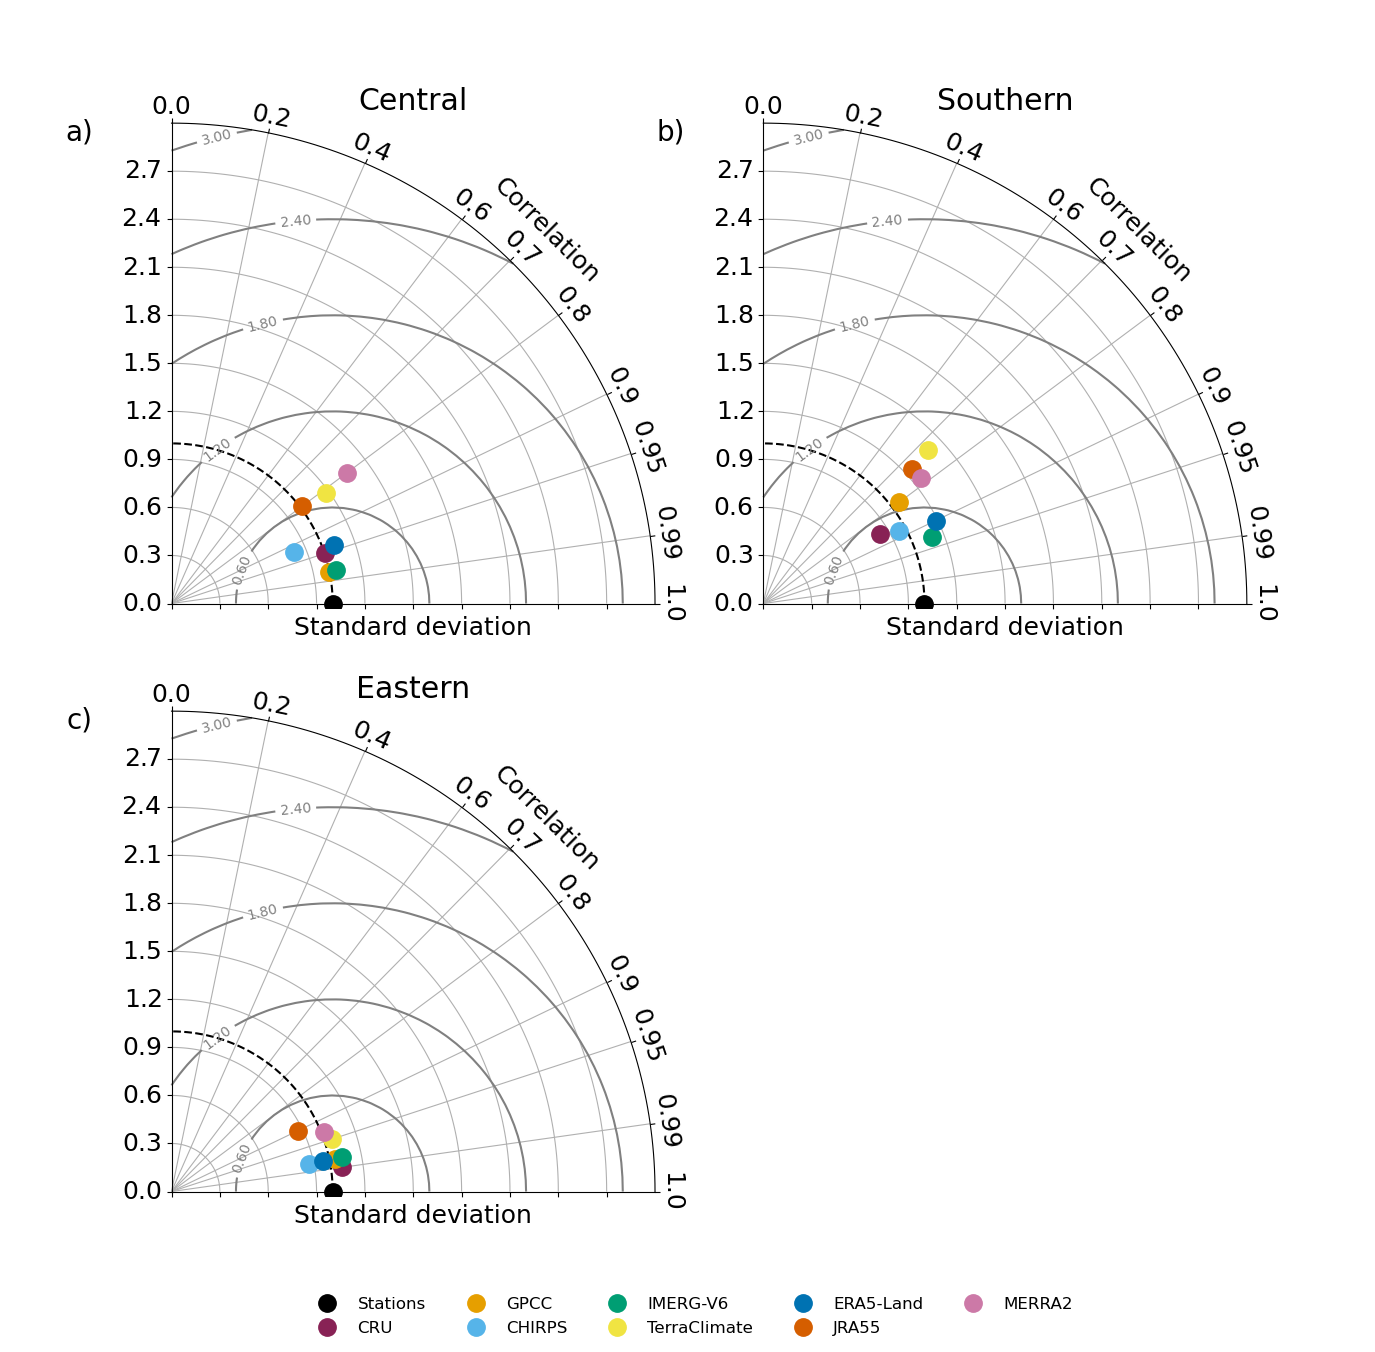

In [123]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
letters_ts = ['a)', 'b)', 'c)', 'd)']

mss = 25
for i, region in enumerate(regions_list ):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 3),mss =mss)
# Create a figure and a gridspec layout

    df_reg = df_corr[df_corr.Region == region]
    # Add samples to Taylor diagram
    contours = dia.add_contours(colors='0.5')
    for j, name in enumerate(datasets_names):
        df_set = df_reg[df_reg['Dataset'] == name]
        std = df_set['sd'].values[0]
        corr = df_set['corr'].values[0]
        dia.add_sample(std, corr, marker='.', ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name)
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region)
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    
    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, bbox_to_anchor=(0.5, 0.0), loc='lower center', ncol=5, frameon=False, fontsize=12)

#legend in the middle outside of the plot
plt.tight_layout()

# point to pixel

In [124]:
df_stat = pd.read_csv(r'Data\Datasets\Cerrado_map\stations_ts.csv', index_col=0)
#merge with stations to get the region
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr', 'Date':'year'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])


In [135]:
def create_metrics_dataframe(metrics_dict, datasets_names, regions_replace=regions_replace):
    df_metrics = pd.DataFrame()

    for name in datasets_names:
        ds = metrics_dict[name]
        dff = ds.to_dataframe().dropna().reset_index()
        dff['Dataset'] = name
        df_metrics = df_metrics.append(dff)
        
    df_metrics = df_metrics[['lat', 'lon', 'corr', 'rmse', 'mae', 'mape', 'kge', 'nse', 'pbias', 'Region', 'Dataset']]\
        .rename(columns={'Region': 'Region'})
    
    df_metrics['Region'] = df_metrics['Region'].replace(regions_replace)
    
    return df_metrics

In [136]:
from Data.utils.evaluation import calculate_metrics, create_metrics_dataframe,  datasets_05
from Data.utils.datasets_plotting import plot_datasets33_nostat
metrics_dict = calculate_metrics(data, datasets_names, ds_dict, 'pr')
df_metrics = create_metrics_dataframe(metrics_dict, datasets_names,regions_replace=regions_replace)
metrics_dict_05 = datasets_05(metrics_dict, ds_dict, datasets_names)

C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\2853131971.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\2853131971.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\2853131971.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\2853131971.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2578

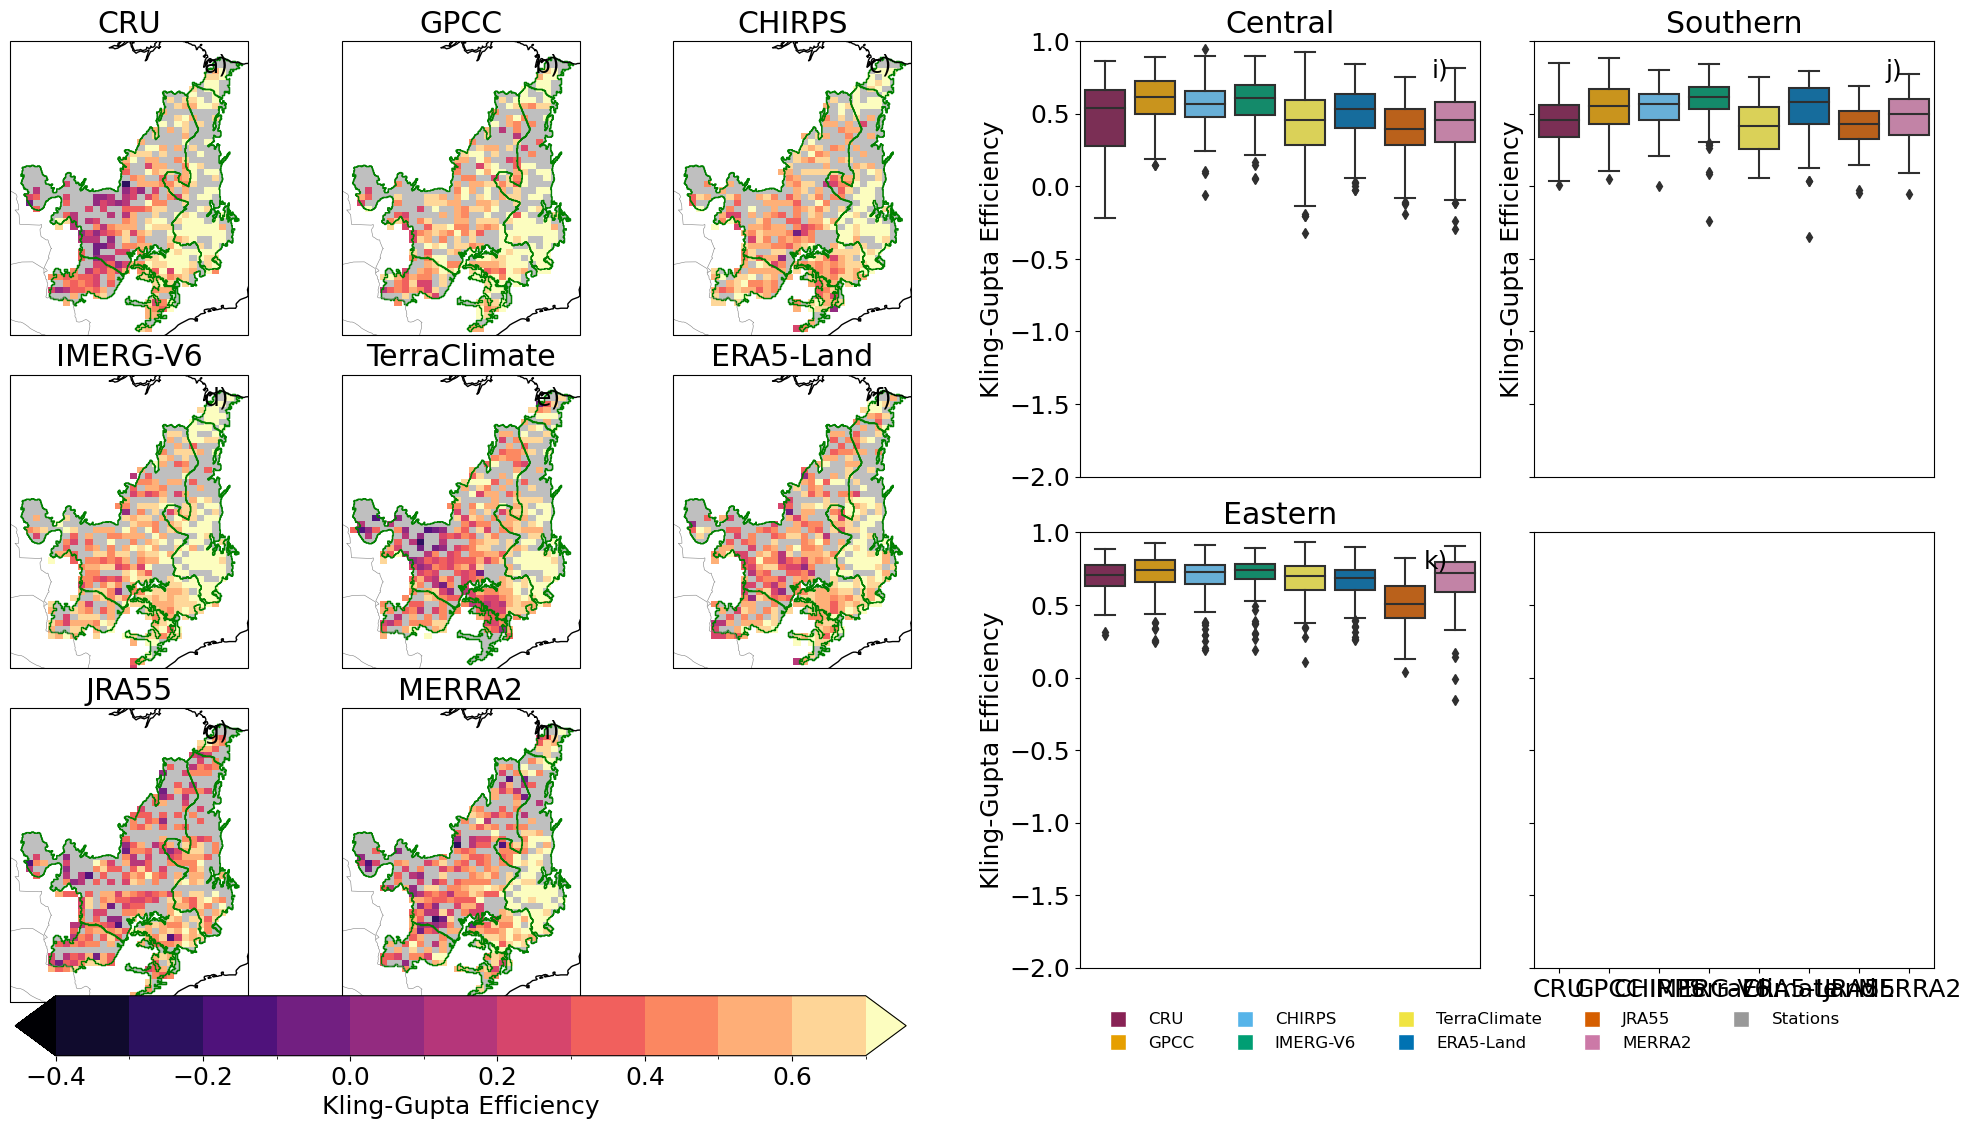

In [140]:
letters_22_eva = ['i)','j)', 'k)', 'l)']
vmin = -0.4
vmax = 0.7
levels = 12
cmap =  mpl.cm.magma
extend_cbar = 'both'
var = 'kge'
var_stat = 'kge'
label_cbar = 'Kling-Gupta Efficiency'
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([-2, 1])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
    
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar,extent = extent)


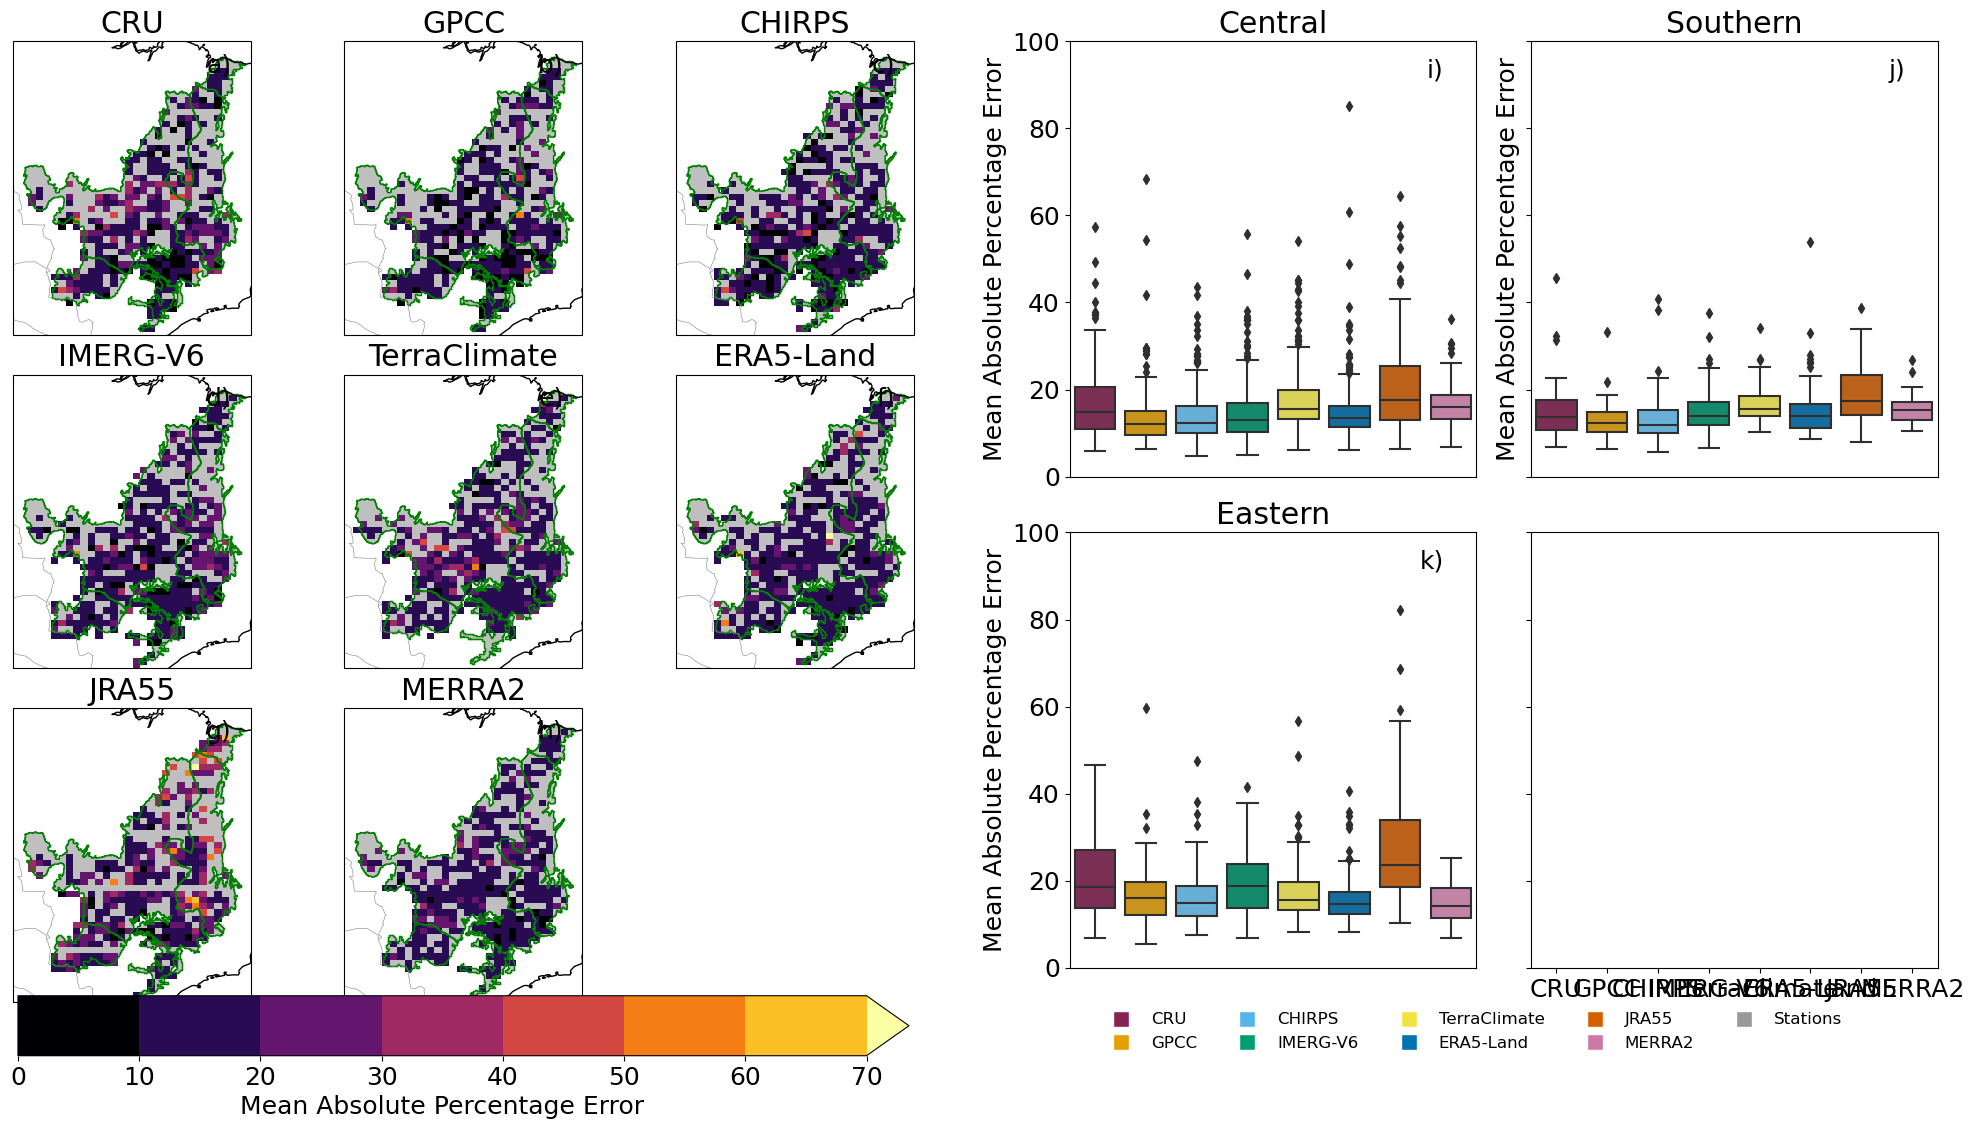

In [138]:

vmin = 0
vmax = 70
levels = 8
cmap =  mpl.cm.inferno
extend_cbar = 'max'
var = 'mape'
var_stat = 'Total'
label_cbar = 'Mean Absolute Percentage Error'
letters_22_eva = ['i)','j)', 'k)', 'l)']
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df_metrics
    sns.boxplot( y=var, data=df_metrics[df_metrics.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) 
    axs_right[i].set_ylabel(label_cbar)
    axs_right[i].set_ylim([vmin, 100])
    axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
plot_datasets33_nostat(subfigs[0], datasets_names, metrics_dict_05,  regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar, extent = extent)


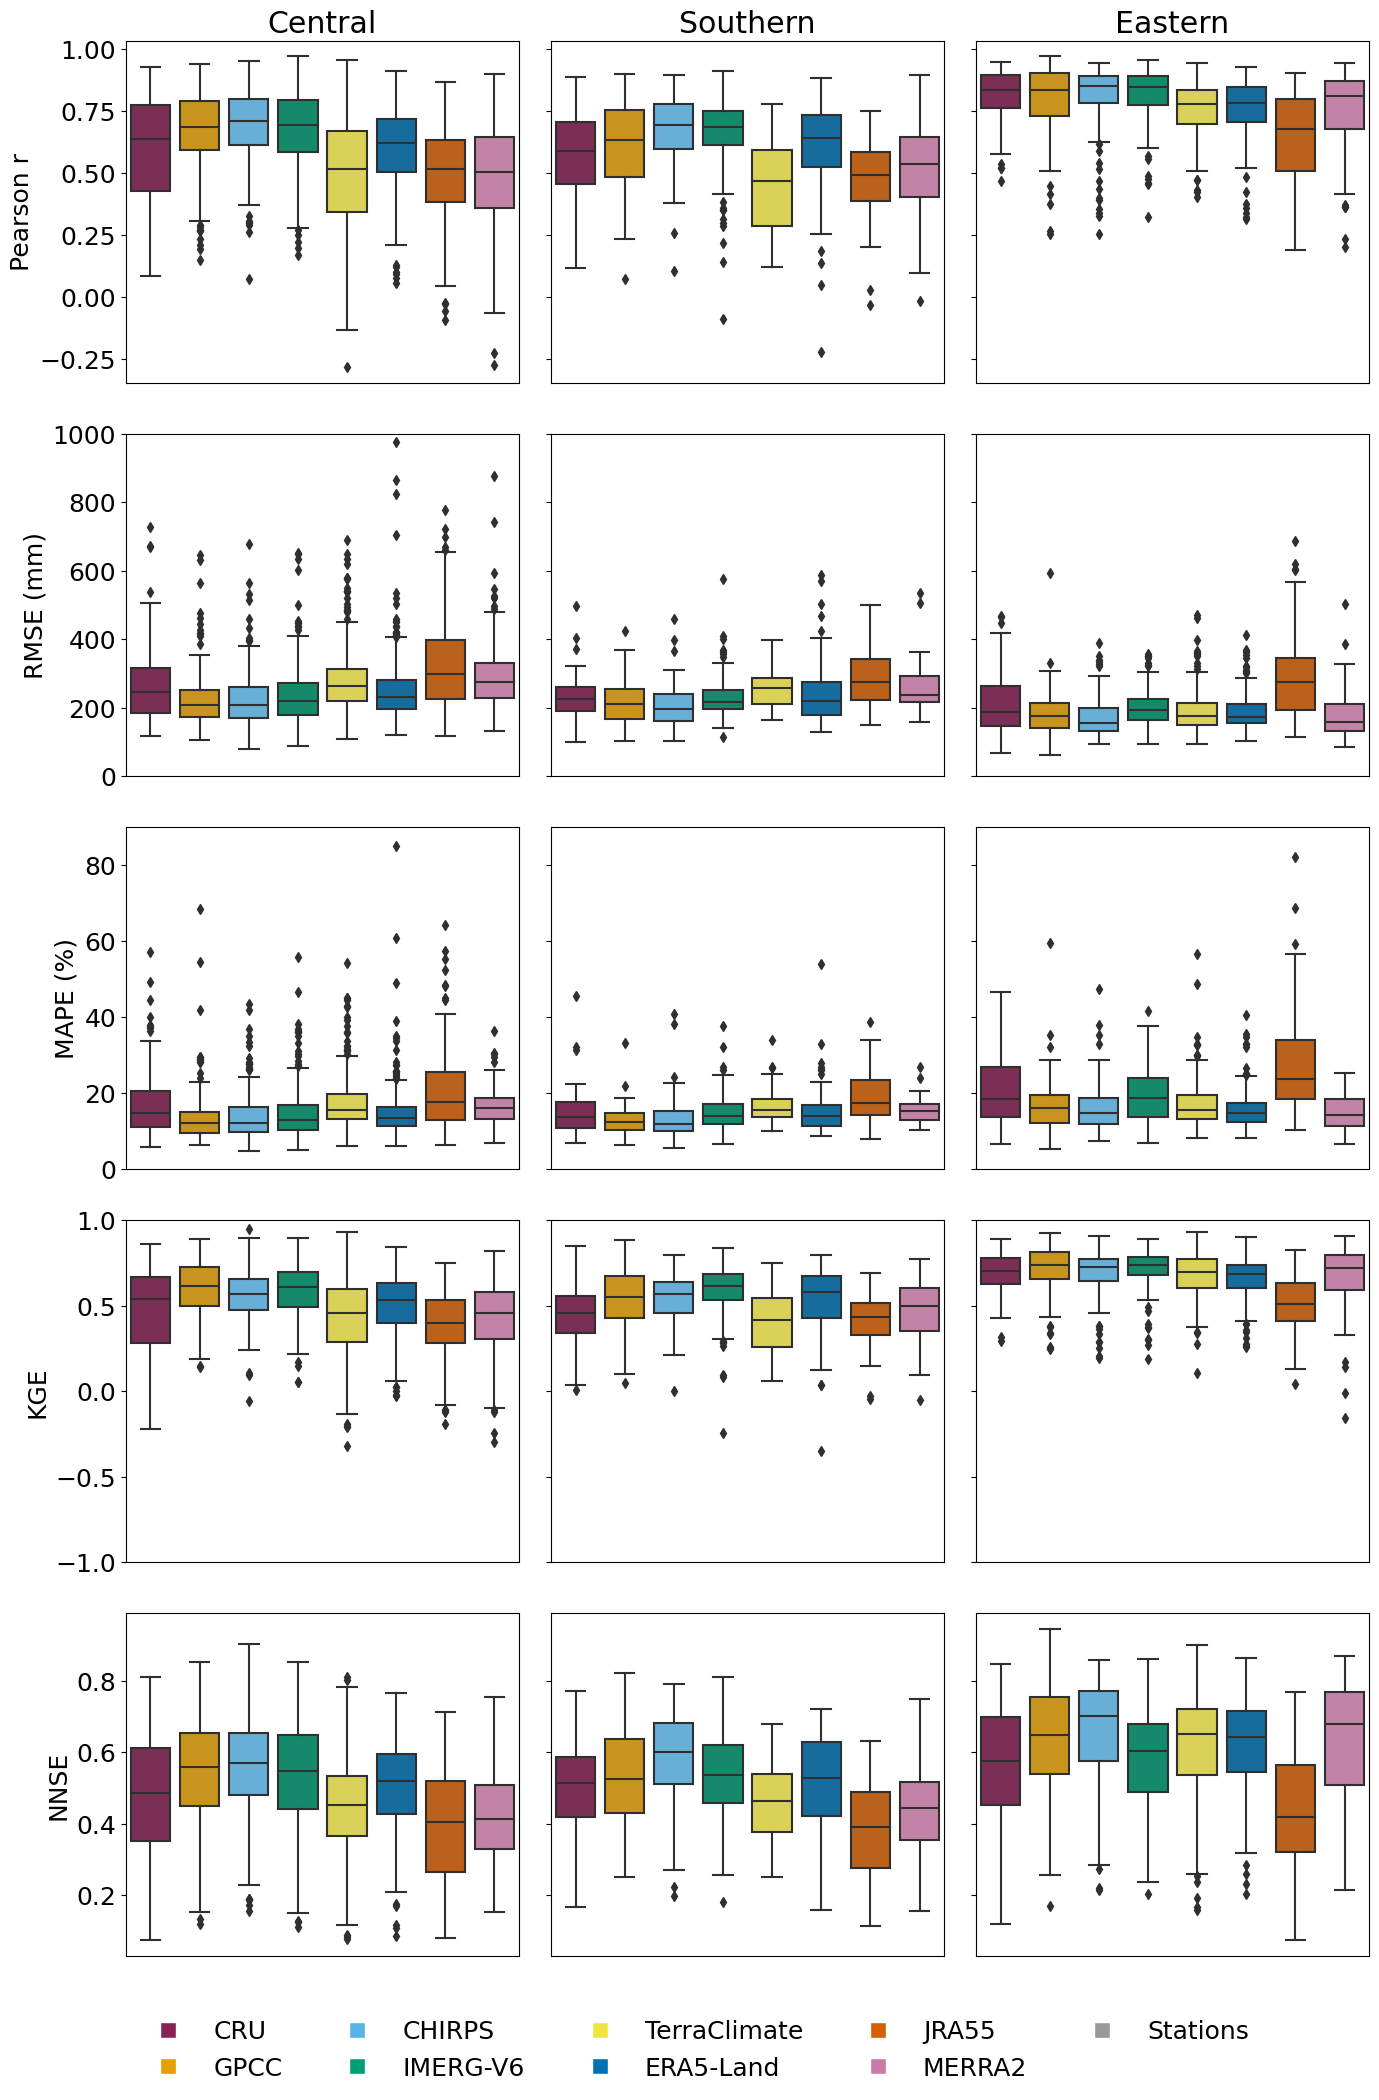

In [143]:
df_metrics['nnse'] = 1/(2-df_metrics['nse'])
metrics_plot = ['corr','rmse', 'mape', 'kge','nnse']
metrics_label = ['Pearson r', 'RMSE (mm)', 'MAPE (%)', 'KGE', 'NNSE']

fig, axes = plt.subplots(len(metrics_plot), 3, figsize = (14, 20), sharey='row')
for i, metric in enumerate(metrics_plot):
    for j, region in enumerate(regions_list):
        #box plot
        df_region = df_metrics[df_metrics.Region == region]
        sns.boxplot( y=metric, data=df_region, ax=axes[i,j], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
        #axes[i,j].set_title(region)
        axes[i,j].set_xlabel('')
        axes[i,j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
        if j == 0:
            axes[i,j].set_ylabel(metrics_label[i])
        else:
            axes[i,j].set_ylabel('')
        if i == 0:
            axes[i,j].set_title(region)

axes[1,0].set_ylim(0,1000)
axes[2,0].set_ylim(0,90)
axes[3,0].set_ylim(-1,1)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

plt.tight_layout()

In [142]:
df_metrics.groupby(['Region', 'Dataset']).mean()

lat        lon      corr        rmse         mae  \
Region   Dataset                                                                
Central  CHIRPS       -15.295968 -49.525806  0.691919  221.211849  179.919344   
         CRU          -14.653153 -49.765766  0.591118  263.726169  219.912360   
         ERA5-Land    -15.240653 -49.346292  0.601020  251.800509  207.141154   
         GPCC         -14.653153 -49.765766  0.671533  223.608997  179.971639   
         IMERG-V6     -15.353519 -49.307478  0.672221  233.634437  191.832058   
         JRA55        -14.535438 -49.861574  0.497557  327.468031  277.752168   
         MERRA2       -14.448598 -49.891939  0.494979  291.318883  236.204290   
         TerraClimate -15.283922 -49.316943  0.496824  280.133953  230.418514   
Eastern  CHIRPS       -14.225746 -44.962687  0.805318  171.754010  140.066063   
         CRU          -13.799451 -45.041209  0.810336  215.847099  184.249506   
         ERA5-Land    -14.395425 -44.856864  0.761278  189.380970  154.204301   
         GPCC         -13.799451 -45.041209  0.790699  182.323952  149.498027   
         IMERG-V6     -14.389310 -44.842413  0.816438  198.783887  166.380497   
         JRA55        -13.603727 -45.055812  0.656595  291.102475  251.153872   
         MERRA2       -14.018519 -45.084877  0.746321  177.746767  141.922561   
         TerraClimate -14.314156 -44.821054  0.757201  191.554393  157.740770   
Southern CHIRPS       -21.341463 -52.036585  0.668376  203.906358  160.211729   
         CRU          -21.287037 -52.268519  0.571633  230.945327  187.063546   
         ERA5-Land    -21.465657 -51.646464  0.595988  241.462757  193.942749   
         GPCC         -21.287037 -52.268519  0.611632  215.501047  167.674753   
         IMERG-V6     -21.462371 -51.747938  0.656737  233.377348  183.100084   
         JRA55        -21.270047 -53.095161  0.467618  290.363901  243.222164   
         MERRA2       -21.204082 -52.627551  0.511776  258.666175  206.454712   
         TerraClimate -20.880133 -52.625906  0.455721  255.244315  204.067372   

                            mape       kge       nse      pbias      nnse  
Region   Dataset                                                           
Central  CHIRPS        13.850645  0.558740  0.070963  -6.131067  0.561720  
         CRU           16.768410  0.478675 -0.455080  -8.981507  0.481264  
         ERA5-Land     14.838467  0.511914 -0.202026   2.282042  0.505485  
         GPCC          13.483145  0.598101 -0.028306  -4.272995  0.547336  
         IMERG-V6      14.585517  0.581227 -0.070093  -7.199125  0.538774  
         JRA55         20.354051  0.392686 -1.124589  -3.273680  0.393608  
         MERRA2        16.388731  0.427534 -0.623079   7.474665  0.423333  
         TerraClimate  17.303198  0.436111 -0.528696  -6.658536  0.452013  
Eastern  CHIRPS        16.288555  0.690252  0.360331  -7.854816  0.657720  
         CRU           20.668104  0.685883 -0.099625 -14.787037  0.561259  
         ERA5-Land     16.048856  0.665866  0.269058   2.389670  0.616635  
         GPCC          16.580020  0.706208  0.235854  -7.519200  0.626033  
         IMERG-V6      19.299585  0.713623  0.182477 -13.653161  0.588532  
         JRA55         27.676117  0.509840 -1.044291 -15.890166  0.432998  
         MERRA2        14.981169  0.659523  0.257321  -0.359014  0.633637  
         TerraClimate  17.298957  0.673808  0.194553  -6.415717  0.613715  
Southern CHIRPS        13.342486  0.539866  0.155808  -4.290325  0.583398  
         CRU           15.194236  0.443232 -0.233929  -4.456683  0.498659  
         ERA5-Land     15.215480  0.528045 -0.093375   1.018131  0.520287  
         GPCC          13.006758  0.538992 -0.056398  -0.677928  0.528778  
         IMERG-V6      15.232731  0.578264 -0.013077  -7.071869  0.529018  
         JRA55         19.004111  0.413388 -0.915296  -0.165981  0.391681  
         MERRA2        15.269606  0.455537 -0.498624   8.399803  0.439937  
         TerraClimate 

In [144]:
df_metrics_mean = df_metrics.groupby(['Region', 'Dataset']).mean().reset_index()#.set_index('Dataset').groupby('Region')
df_metrics_mean = df_metrics_mean.set_index('Dataset').groupby('Region')
#get a table with the best dataset for each metric and region
metrics_min = ['rmse','mae','mape']
metrics_max = ['corr','kge','nse']
df_metrics_best = df_metrics_mean[metrics_max].idxmax()
df_metrics_best[metrics_min] = df_metrics_mean[metrics_min].idxmin() 
df_metrics_best
#df_metrics_mean[['corr','rmse','mae','mape','kge','nse','pbias']].reset_index().set_index('Dataset').groupby('Region').idxmax()

corr       kge     nse    rmse     mae    mape
Region                                                      
Central     CHIRPS      GPCC  CHIRPS  CHIRPS  CHIRPS    GPCC
Eastern   IMERG-V6  IMERG-V6  CHIRPS  CHIRPS  CHIRPS  MERRA2
Southern    CHIRPS  IMERG-V6  CHIRPS  CHIRPS  CHIRPS    GPCC

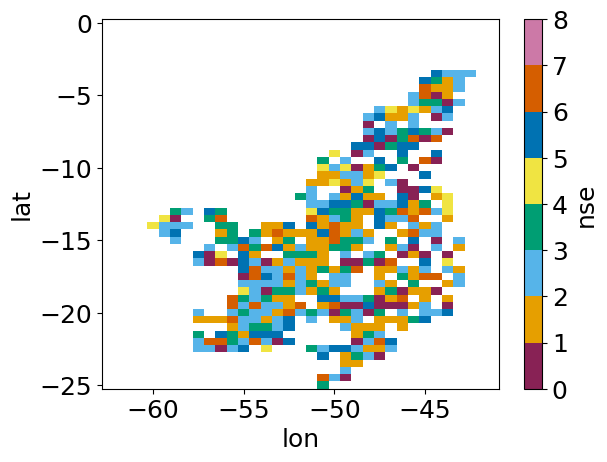

In [145]:
#merge all metrics_dict_05 in one xarray dataset
_ds = list(metrics_dict_05.values())
_coord = list(metrics_dict_05.keys())
ds_out_05 = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'Dataset'})
#create cmap from palette wong
from matplotlib.colors import ListedColormap
cmap = ListedColormap(wong[:-1])
ds_out_05['Dataset'] = [0,1,2,3,4,5,6,8]
#from ds_out_05 create a dataset with the best Dataset for each pixel
ds_out_05.idxmax(dim='Dataset').nse.plot(levels=9, cmap=cmap)


# trend

In [149]:
stations = gpd.read_file(r'Data\Datasets\Cerrado_map\stations.geojson')

folder_metric = r'Data\Datasets\Cerrado_map\trend'
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds['trend_ratio'] = ds['slopes'] / ds['intercepts']  * 100
    ds_dict[datasets_names[i]] = ds

#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['Region', 'Dataset', 'slopes', 'intercepts', 'p_values','trend_ratio']]
df['Region'] = df['Region'].replace(regions_replace)
stations['trend_ratio'] = stations['slope_anual'] / stations['intercept_anual'] * 100
df_stat = stations[['p_anual', 'slope_anual','intercept_anual', 'Region','trend_ratio']].copy()
df_stat['Dataset'] = 'Stations'
df_stat = df_stat.rename(columns={'p_anual':'p_values', 'slope_anual':'slopes', 'intercept_anual':'intercepts'})
df = df.append(df_stat)

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\695061139.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\695061139.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

In [151]:
vmin = -3#40
vmax = 3#40
levels = 17
cmap =  mpl.cm.BrBG
extend_cbar = 'both'
var = 'trend_ratio'#'slopes'
var_stat ='trend_ratio' #'slope_anual'
label_cbar = 'Trend (%/year)'#'MAP trend(mm/year/year)'

In [150]:
#import mpatches
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.colors as colors
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 18})
legend_elements_sig = [ (mpatches.Patch(facecolor='grey', edgecolor='black', hatch='///'),
                        Line2D([0], [0],  marker='o', color='w', markerfacecolor='grey', markersize=12, markeredgewidth=1.5, markeredgecolor='black')),
                          (mpatches.Patch(facecolor='grey', edgecolor='black'),
                           Line2D([0], [0],  marker='o', color='w', markerfacecolor='none', markersize=12, markeredgecolor='black', markeredgewidth=1.5))]
def plot_datasets33_trend_sig(subfigg, datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar, extent=[-81, -42, -20, 11], proj=ccrs.Mercator(), ms=40):
    """
    Plot multiple datasets along with station and regional data on a grid of subplots.

    Parameters:
        datasets_names (list): A list of dataset names to plot.
        ds_dict (dict): A dictionary containing datasets with keys as dataset names and values as data arrays.
        stations (geopandas.GeoDataFrame): A GeoDataFrame containing station data.
        regions (geopandas.GeoDataFrame): A GeoDataFrame containing regional data.
        vmin (float): Minimum value for the color scale.
        vmax (float): Maximum value for the color scale.
        levels (int): Number of levels in the color scale.
        proj (cartopy.crs.Projection): The projection for the subplots.
        cmap (matplotlib.colors.Colormap): The colormap for the plots.
        extend_cbar (str): The colorbar extension ('min', 'max', or 'both').
        var (str): The variable key in the datasets to plot.
        var_stat (str): The variable key in the station GeoDataFrame to plot.
        extent (list): The geographical extent of the plot [min_lon, max_lon, min_lat, max_lat].
        label_cbar (str): Label for the colorbar.

    Returns:
        None

    Example:
        # Define the required variables
        vmin = -400
        vmax = 0.01
        levels = 9
        proj = ccrs.Mercator()
        cmap = cm.lajolla
        extend_cbar = 'min'
        var = 'mcwd'
        var_stat = 'mcwd'
        extent = [-81, -42, -20, 11]
        label_cbar = 'Maximum Cumulative Water Deficit (mm)'

        # Call the function to plot the datasets
        plot_datasets(datasets_names, ds_dict, stations, regions, vmin, vmax, levels, proj, cmap, extend_cbar, var, var_stat, extent, label_cbar)
    """
   
    
    bounds = np.linspace(vmin, vmax, levels)
    norm = colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    
    axes = subfigg.subplots(3, 3, subplot_kw={'projection': proj})
    axes = axes.flatten()
    # Color bar
    cax = subfigg.add_axes([0.05, -0.12, 0.9, 0.06])
    subfigg.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar)
    
    # Loop through the datasets and plot them
    for i, name in enumerate(datasets_names):
        ax = axes[i]
        ds = ds_dict[name]
        im = ds[var].plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels, extend=extend_cbar)
        ds[var].where(ds.p_values <= 0.05).plot.contourf(ax=ax, colors='none', hatches=['///'], add_colorbar=False,transform=ccrs.PlateCarree())
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axes[i].set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(name)
    
    ax_stat = axes[-1]
    ax_stat.coastlines(transform=ccrs.PlateCarree())
    ax_stat.add_geometries(cf.BORDERS.geometries(), crs=proj, linewidth=0.4, edgecolor='grey', facecolor='none', zorder=0)
    ax_stat.add_geometries(cf.COASTLINE.geometries(), crs=proj, linewidth=1, edgecolor='black', facecolor='none', zorder=0)
    #stations.plot(ax=ax_stat, column=var_stat, cmap=cmap, scheme="User_Defined",
    #              classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black')
    stations[stations.p_anual > 0.05].plot(edgecolor=cmap(norm(stations[var_stat].values)), linewidth=1.5, marker='o', markersize=ms,
                                           legend=False,facecolor='none',ax=ax_stat)    

    stations[stations.p_anual <= 0.05].plot( column=var_stat, cmap=cmap, scheme="User_Defined", markersize=ms*1.2,
                  classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black',ax=ax_stat)
    #create legend of significant and non-significant stations and plot it in the lower right corner

    subfigg.legend(handles=legend_elements_sig,labels=[r'p <= 0.05', 'p > 0.05'],handler_map={tuple: HandlerTuple(ndivide=None)},
                    bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=2, frameon=False, fontsize=15)
    ax_stat.set_title('Stations')
    regions.plot(ax=ax_stat, facecolor='none', edgecolor='green', linewidth=1, alpha=0.7)
    ax_stat.set_xlim(extent[0], extent[1])
    ax_stat.set_ylim(extent[2], extent[3])

    letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    for i in range(len(datasets_names)+1):
        axes[i].text(0.92,0.96,  letters[i], transform=axes[i].transAxes,  fontsize=18, va='top', ha='right')


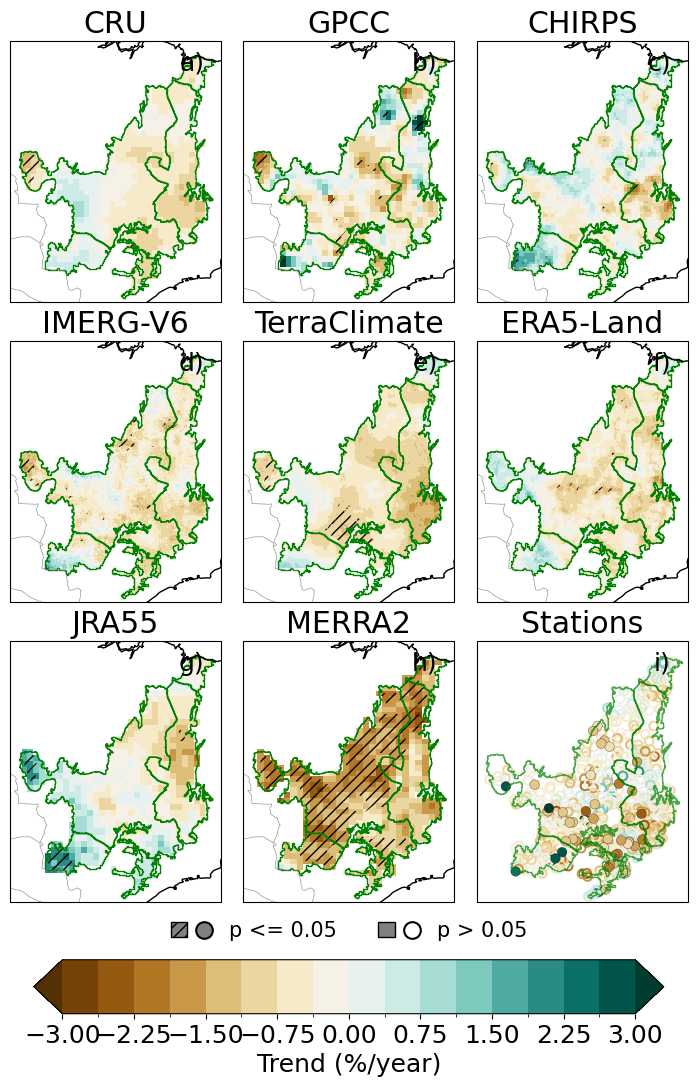

In [152]:
fig = plt.figure(layout='constrained', figsize=(7, 9))
plot_datasets33_trend_sig(fig, datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar, extent=extent)


In [153]:
#create a significant column for df
df['Significancy'] = df['p_values'] <= 0.05
df['Significancy'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)
df_all = df.copy()
df_all['Significancy'] = 'All'
df_sig = df[df['Significancy'] == 'Significant']
df_all = pd.concat([df_all, df_sig])

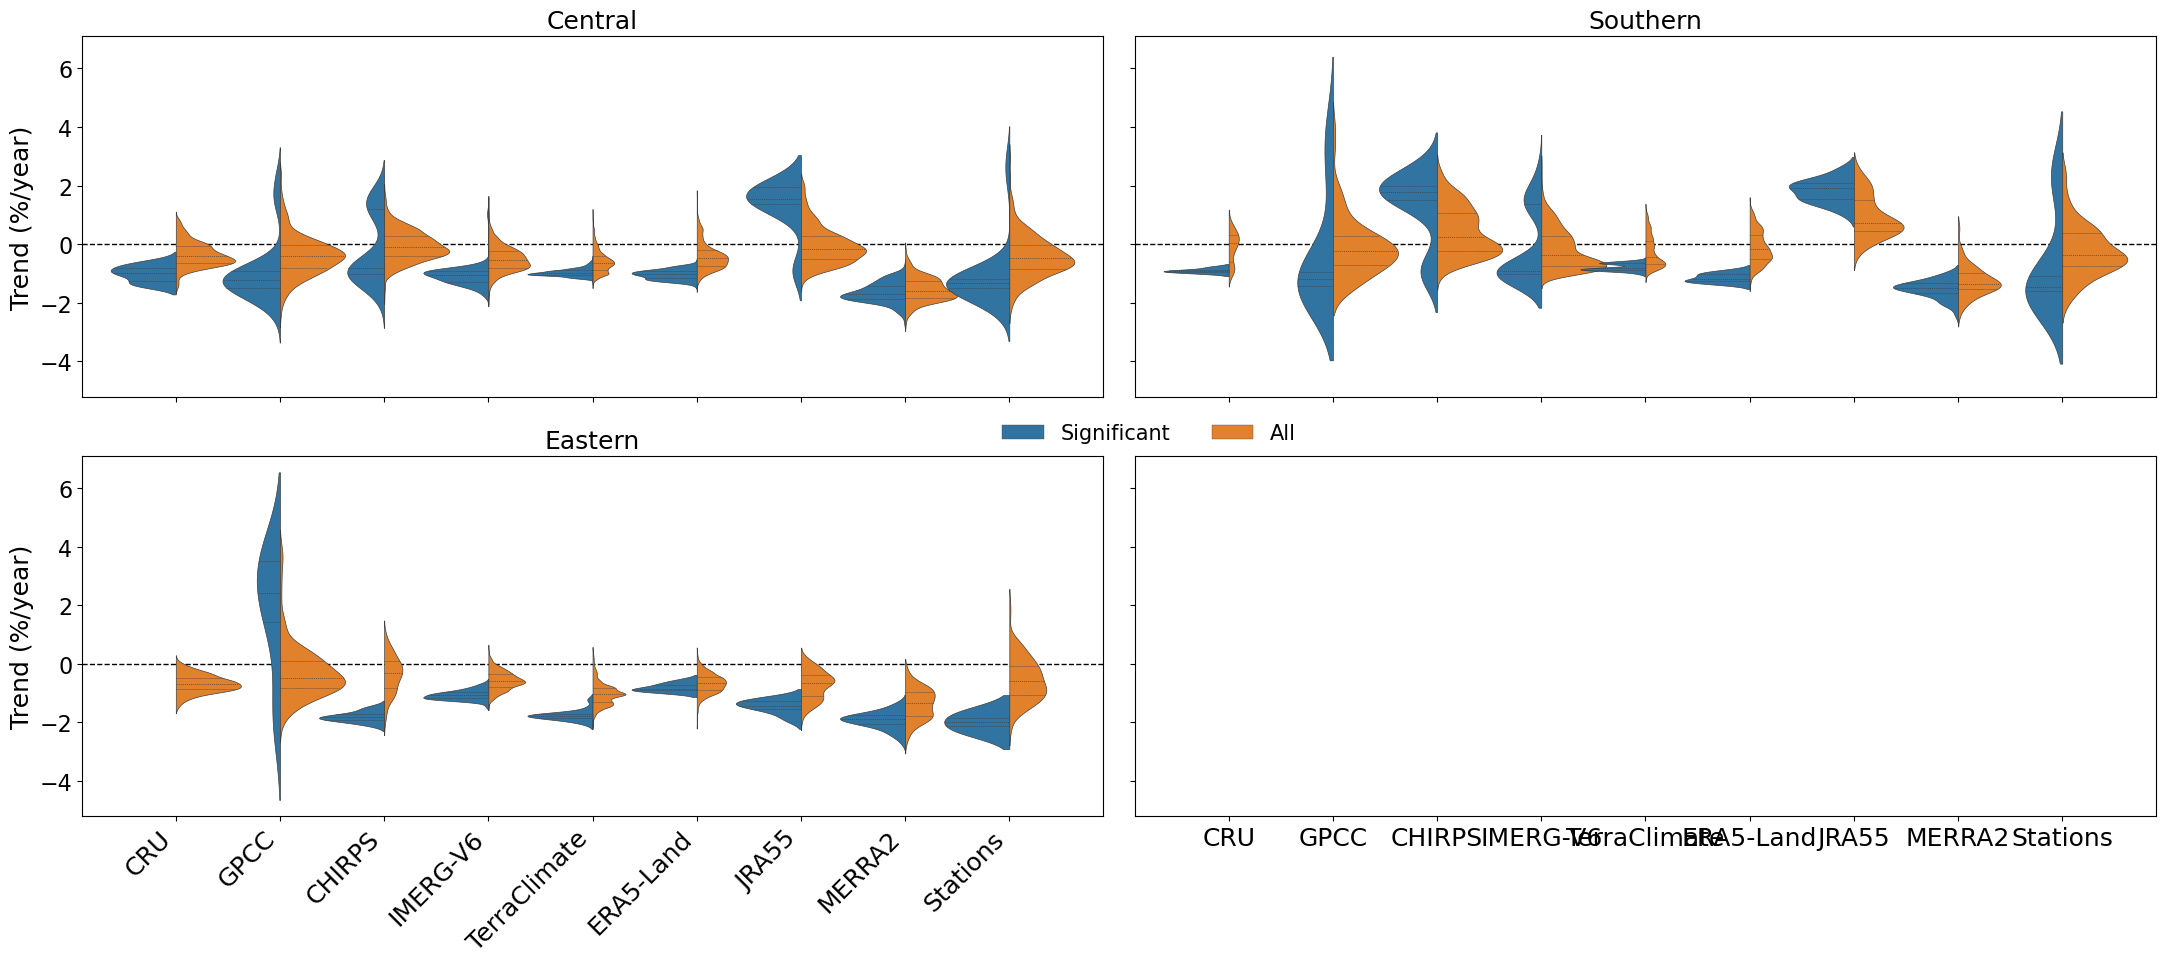

In [161]:
#plot violinplot of df_all with significant column for each region and dataset
fig, axes = plt.subplots(2,2, figsize=(22,10), sharex=True, sharey=True)
#font size as 12
plt.rcParams.update({'font.size': 18})
axes = axes.flatten()
for i, region in enumerate(regions_list):
    ax = axes[i]
    sns.violinplot(data=df_all[df_all.Region==region], x='Dataset', y=var, hue='Significancy', 
                   hue_order=['Significant', 'All'], ax=ax, split=True,  
                   linewidth=0.5,width=1.25, inner='quartile',scale='area')
    ax.set_title(region, fontsize=18)
    #set x lim 
    ax.set_xlim(-0.9, 8.9)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #leave only the legend for last subplot
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    ax.tick_params(axis='y', which='both', labelsize=16)
    #set ticks label 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    #horizontal line in 0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)
    if i % 2 == 0:
        ax.set_ylabel(label_cbar, fontsize=18)
    else:
        ax.set_ylabel('')

#take the legend from axes[3], to figure and place it in the centeer
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.53, 0.52), loc='lower center', ncol=2, frameon=False, fontsize=15)
plt.tight_layout()


## point comparinson

In [155]:
stations['trend_ratio'] = stations['slope_anual'] / stations['intercept_anual'] * 100
data = stations[['geometry','slope_anual','trend_ratio']].copy()
data = data.rename(columns={'slope_anual':'slopes'})
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'trend_ratio'
metrics_dict = {}
for name in datasets_names:
    ds = ds_dict[name].copy()
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    for var in ['trend_ratio', 'slopes']:

        # Step 3: Compute the mean value for each grid cell and each year
        grid_cells = data.groupby(['lat_bin', 'lon_bin'])[var].mean().reset_index()
        # Step 4: Create an empty DataArray with NaN values
        empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)
        # Step 5: Fill the DataArray with the computed mean values for each year
        for _, row in grid_cells.iterrows():
            #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            empty_grid[lat_idx - 1, lon_idx - 1] = row[var]
        # Step 6: Create an xarray DataArray from the result with the year dimension
        #year_coords = data['year'].unique()
        data_array = xr.DataArray(empty_grid,
                                    dims=('lat', 'lon'),
                                    coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
        # Calculate various metrics
        ds[var + '_stat'] = data_array
    metrics_dict[name] = ds

In [156]:
df_compare = pd.DataFrame()
for name in datasets_names:
    df_comparef =  metrics_dict[name].to_dataframe().dropna().reset_index(drop=True)
    df_comparef['Dataset'] = name
    df_compare = df_compare.append(df_comparef)

df_compare = df_compare[['p_values', 'Region', 'Dataset','trend_ratio', 'trend_ratio_stat', 'slopes','slopes_stat']]
df_compare['Region'] = df_compare['Region'].replace(regions_replace)
#create significant column, if the row has pvalue less than 0.05 is significant
df_compare['significant'] = df_compare['p_values'] < 0.05
df_compare['significant'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)


C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_25780\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\A

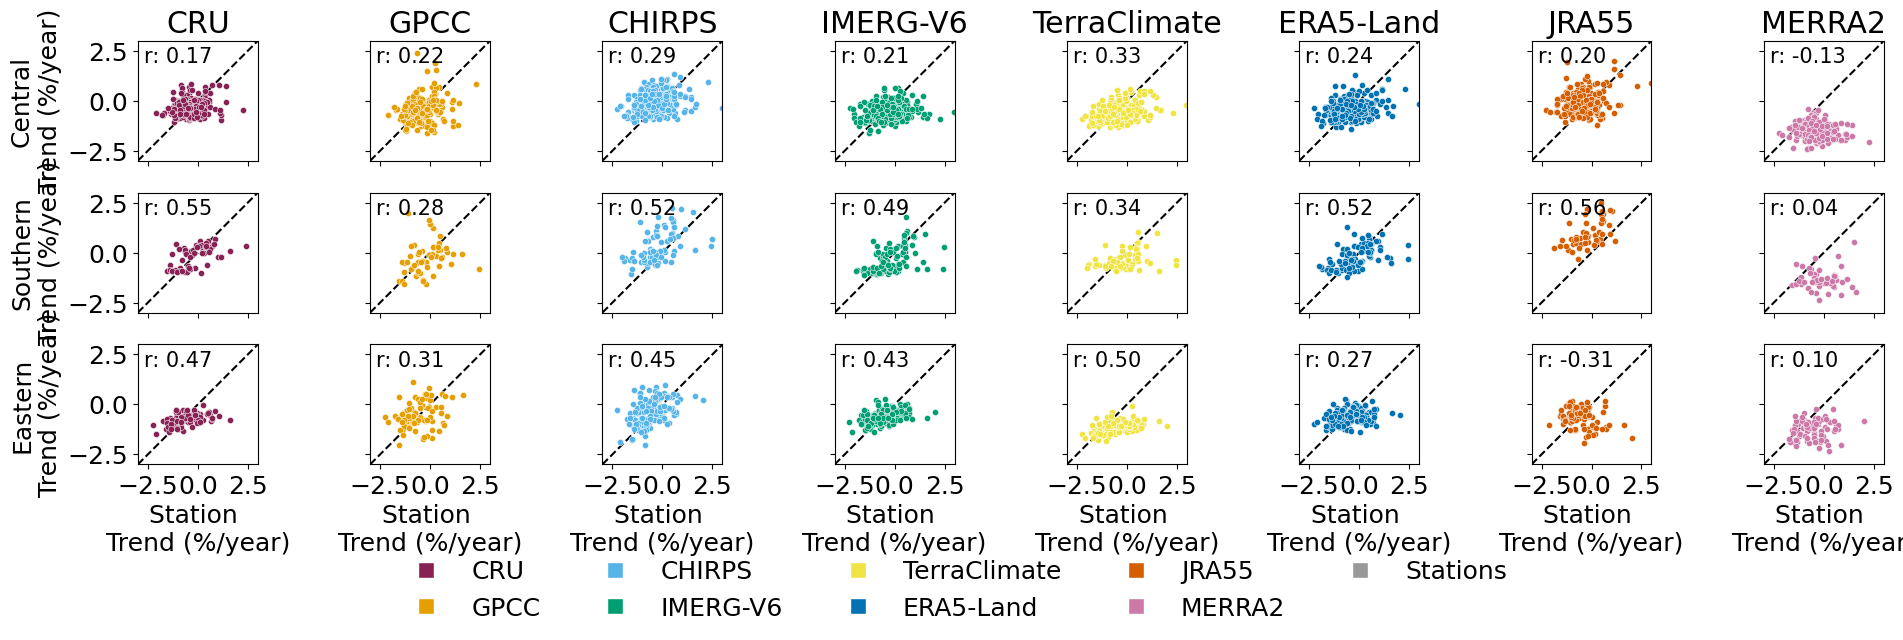

In [162]:
var = 'trend_ratio'
fig, axes = plt.subplots(3,8, figsize=(20,6), sharex=True, sharey=True)
limm = 3
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='trend_ratio_stat', y='trend_ratio', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[j,i].set_xlabel('Station \nTrend (%/year)')
        axes[j,i].set_ylabel(region + '\nTrend (%/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['trend_ratio_stat'].corr(df_plot['trend_ratio'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()